<b>

<p>
<center>
<font size="5">
Stanford Dog Breed Classification with Transfer Learning
</font>
</center>
</p>




</b>

# Notebook Configuration

## Google Drive

In [0]:
import os

In [5]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Get absolute path
abspath = '/content/drive/My Drive/Colab Notebooks/DATS 6202/Final/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
os.chdir(abspath)
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/DATS 6202/Final'

## Warning

In [0]:
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

## Matplotlib

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Set matplotlib sizes
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)

## TensorFlow

In [0]:
# The magic below allows us to use tensorflow version 2.x
%tensorflow_version 2.x 
import tensorflow as tf
from tensorflow import keras

# Data Preprocessing

## Loading Data

In [0]:
# Make directory
directory = os.path.dirname(abspath + 'data/')
if not os.path.exists(directory):
    os.makedirs(directory)

In [0]:
# Download dog image data to the data directory
import tensorflow_datasets as tfds

# Get the name of the data
data_name = 'stanford_dogs'

# Load data
data, info = tfds.load(name=data_name,
                       data_dir=abspath + 'data/',
                       as_supervised=True,
                       with_info=True)

## Get Name of Target

In [0]:
target = 'label'

## Get the Info

In [13]:
# Look at what is stored in data variable
data

{'test': <DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>,
 'train': <DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>}

In [14]:
# Look at all info
# Notice the split information - 8580 images for test and 12000 for train
info

tfds.core.DatasetInfo(
    name='stanford_dogs',
    version=0.2.0,
    description='The Stanford Dogs dataset contains images of 120 breeds of dogs from around
the world. This dataset has been built using images and annotation from
ImageNet for the task of fine-grained image categorization. There are
20,580 images, out of which 12,000 are used for training and 8580 for
testing. Class labels and bounding box annotations are provided
for all the 12,000 images.
',
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        }),
    }),
    total_num_examples=20580,
    splits={
        'test': 8580,
        'train': 12000,
    },
    supervised_keys=('image

In [15]:
# Get the classes
classes = info.features['label'].names

# Print the classes
print(classes)

# We can see that there are 120 dog breeds
print('Number of classes: ' + str(len(classes)))

# Get the number of classes
n_classes = info.features['label'].num_classes

['n02085620-chihuahua', 'n02085782-japanese_spaniel', 'n02085936-maltese_dog', 'n02086079-pekinese', 'n02086240-shih-tzu', 'n02086646-blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-rhodesian_ridgeback', 'n02088094-afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-walker_hound', 'n02089973-english_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-irish_wolfhound', 'n02091032-italian_greyhound', 'n02091134-whippet', 'n02091244-ibizan_hound', 'n02091467-norwegian_elkhound', 'n02091635-otterhound', 'n02091831-saluki', 'n02092002-scottish_deerhound', 'n02092339-weimaraner', 'n02093256-staffordshire_bullterrier', 'n02093428-american_staffordshire_terrier', 'n02093647-bedlington_terrier', 'n02093754-border_terrier', 'n02093859-kerry_blue_terrier', 'n02093991-irish_terrier', 'n02094114-norfolk_terrier', 'n02094258-norwich_terrier', 'n02094433-yorkshire_t

## Getting the training, validation and testing data

In [0]:
# Set the training, validation and testing split
split_train, split_valid, split_test = 'train[:70%]', 'train[70%:]', 'test'

# Get the training data
data_train = tfds.load(name=data_name,
                       split=split_train,
                       data_dir=abspath + 'data/',
                       as_supervised=True)

# Get the validation data
data_valid = tfds.load(name=data_name,
                       split=split_valid,
                       data_dir=abspath + 'data/',
                       as_supervised=True)

# Get the testing data
data_test = tfds.load(name=data_name,
                      split=split_test,
                      data_dir=abspath + 'data/',
                      as_supervised=True)

## Resizing the data for pretrained model

In [0]:
# Set the default input size for the pretrained model
input_size = [299, 299]

In [0]:
def resize(data, label):
    """
    Resize the data into the default input size for the pretrained model

    Parameters
    ----------
    data: the data
    label: the label
    
    Returns
    ----------
    The resized data
    """

    # Resize the data into the default input size for the pretrained model
    data_resized = tf.image.resize(data, input_size)

    return data_resized, label

In [19]:
# Look at data_train before resizing
data_train

<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [0]:
# Resize the training data
data_train = data_train.map(resize)

# Resize the validation data
data_valid = data_valid.map(resize)

# Resize the testing data
data_test = data_test.map(resize)

In [21]:
# Confirm resizing
data_train

<DatasetV1Adapter shapes: ((299, 299, 3), ()), types: (tf.float32, tf.int64)>

## Preprocessing the data using pretrained model

In [0]:
# Set the preprocess_input of the pretrained model
preprocess_input = keras.applications.xception.preprocess_input

In [0]:
def preprocess(data, label):
    """
    Preprocess the data using the pretrained model

    Parameters
    ----------
    data: the data
    label: the label
    
    Returns
    ----------
    The preprocessed data
    """

    # Preprocess the data using the pretrained model
    data_preprocessed = preprocess_input(data)

    return data_preprocessed, label

In [0]:
# Preprocess the training data
data_train = data_train.map(preprocess)

# Preprocess the validation data
data_valid = data_valid.map(preprocess)

# Preprocess the testing data
data_test = data_test.map(preprocess)

## Shuffling, batching and prefetching

In [0]:
# Shuffling the training data
data_train = data_train.shuffle(buffer_size=1000, seed=42)

# Set the batch size
batch_size = 16

# Batch and prefetch the training data
data_train = data_train.batch(batch_size).prefetch(1)

# Batch and prefetch the validation data
data_valid = data_valid.batch(batch_size).prefetch(1)

# Batch and prefetch the testing data
data_test = data_test.batch(batch_size).prefetch(1)

# Training
## Creating the directory for the model

In [0]:
# Make directory
directory = os.path.dirname(abspath + 'model/')
if not os.path.exists(directory):
    os.makedirs(directory)

## Building the architecture of the model

In [0]:
# Add the pretrained layers
pretrained_model = keras.applications.xception.Xception(include_top=False, weights='imagenet')

# Add GlobalAveragePooling2D layer
average_pooling = keras.layers.GlobalAveragePooling2D()(pretrained_model.output)

# Add the output layer
output = keras.layers.Dense(n_classes, activation='softmax')(average_pooling)

# Get the model
model = keras.Model(inputs=pretrained_model.input, outputs=output)

## Freezing the pretrained layers

In [0]:
# For each layer in the pretrained model
for layer in pretrained_model.layers:
    # Freeze the layer
    layer.trainable = False

## Setting Callbacks

In [0]:
# Checkpoint callback
checkpoint_cb = keras.callbacks.ModelCheckpoint(abspath + '/model/model.h5',
                                                save_best_only=True)

# Early stopping callback
# Changed patience to 5
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
                                                  restore_best_weights=True)

## Compiling the model
Here we use the default learning rate of Adam optimizer.

In [0]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss='sparse_categorical_crossentropy',    
              metrics=['accuracy'])

## Training the model

In [0]:
# 10 epochs instead of 5
history = model.fit(data_train,
                    epochs=10,
                    validation_data=data_valid,
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/10
525/525 [==============================] - 61s 117ms/step - loss: 1.0960 - accuracy: 0.7889 - val_loss: 0.7382 - val_accuracy: 0.8528
Epoch 2/10
525/525 [==============================] - 60s 114ms/step - loss: 0.5037 - accuracy: 0.8898 - val_loss: 0.8581 - val_accuracy: 0.8589
Epoch 3/10
525/525 [==============================] - 60s 113ms/step - loss: 0.3370 - accuracy: 0.9240 - val_loss: 0.8153 - val_accuracy: 0.8706
Epoch 4/10
525/525 [==============================] - 60s 114ms/step - loss: 0.2819 - accuracy: 0.9398 - val_loss: 1.0808 - val_accuracy: 0.8511
Epoch 5/10
525/525 [==============================] - 60s 115ms/step - loss: 0.2260 - accuracy: 0.9496 - val_loss: 0.9272 - val_accuracy: 0.8728
Epoch 6/10
525/525 [==============================] - 60s 115ms/step - loss: 0.2012 - accuracy: 0.9549 - val_loss: 1.1677 - val_accuracy: 0.8567


## Unfreezing the pretrained layers

In [0]:
# For each layer in the pretrained model
for layer in pretrained_model.layers:
    # Unfreeze the layer
    layer.trainable = True

## Compiling the model
Here we use a lower learning rate (by a factor of 10) of Adam optimizer, so that it is less likely to compromise the pretrained weights.

In [0]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Training the model

In [0]:
# With 10 epochs on rookie
history = model.fit(data_train,
                    epochs=5,
                    validation_data=data_valid,
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/5
525/525 [==============================] - 61s 116ms/step - loss: 0.2328 - accuracy: 0.9379 - val_loss: 0.4575 - val_accuracy: 0.8997
Epoch 2/5
525/525 [==============================] - 62s 117ms/step - loss: 0.1459 - accuracy: 0.9577 - val_loss: 0.4317 - val_accuracy: 0.8994
Epoch 3/5
525/525 [==============================] - 61s 116ms/step - loss: 0.0990 - accuracy: 0.9704 - val_loss: 0.4274 - val_accuracy: 0.8981
Epoch 4/5
525/525 [==============================] - 61s 117ms/step - loss: 0.0724 - accuracy: 0.9770 - val_loss: 0.4234 - val_accuracy: 0.8986
Epoch 5/5
525/525 [==============================] - 60s 115ms/step - loss: 0.0534 - accuracy: 0.9833 - val_loss: 0.4250 - val_accuracy: 0.8967


## Plotting the learning curve

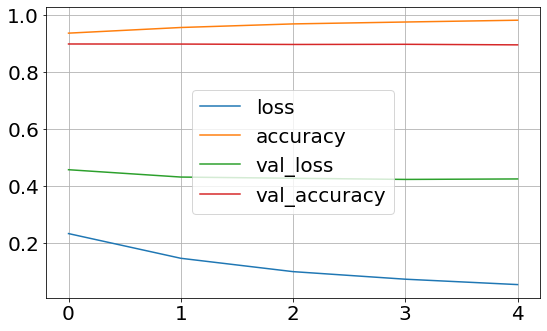

In [0]:
# Create a figure
pd.DataFrame(history.history).plot(figsize=(8, 5))

# Set grid
plt.grid(True)

# Show the figure
plt.tight_layout()
plt.show()

# Testing

## Loading the saved model

In [0]:
model = keras.models.load_model(abspath + '/model/model.h5')

## Evaluating the model

In [0]:
# JG best results with patience = 5 and epochs on rookie = 10
loss, accuracy = model.evaluate(data_test)

537/537 [==============================] - 44s 83ms/step - loss: 0.4696 - accuracy: 0.8964


## Getting Predictions from Images I found Online

I wanted to see for myself how the model performs on images from the internet.

Using TensorFlow backend.


'n02088364-beagle'

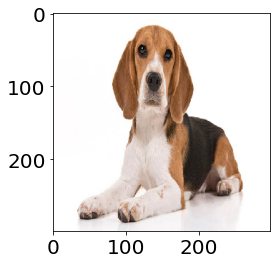

In [27]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

# dimensions of our images
img_width, img_height = 299, 299

# predicting images
img = image.load_img('beagle.jpg', target_size=(img_width, img_height))
x = image.img_to_array(img)
x = np.expand_dims(img, axis=0)/255.

# Get predicted probabilities for 120 class labels
pred_classes = model.predict(x, batch_size=16)

# Display image being classified
plt.imshow(img)

# Get index of highest probability and use it to get class label
classes[np.argmax(pred_classes)]

'n02099712-labrador_retriever'

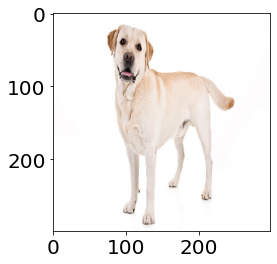

In [0]:
# predicting images
img = image.load_img('labrador_retreiver.jpg', target_size=(img_width, img_height))
x = image.img_to_array(img)
x = np.expand_dims(img, axis=0)/255.

# Get predicted probabilities for 120 class labels
pred_classes = model.predict(x, batch_size=16)

# Display image being classified
plt.imshow(img)

# Get index of highest probability and use it to get class label
classes[np.argmax(pred_classes)]

'n02099601-golden_retriever'

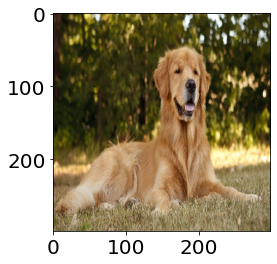

In [0]:
# predicting images
img = image.load_img('golden.jpg', target_size=(img_width, img_height))
x = image.img_to_array(img)
x = np.expand_dims(img, axis=0)/255.

# Get predicted probabilities for 120 class labels
pred_classes = model.predict(x, batch_size=16)

# Display image being classified
plt.imshow(img)

# Get index of highest probability and use it to get class label
classes[np.argmax(pred_classes)]

'n02108915-french_bulldog'

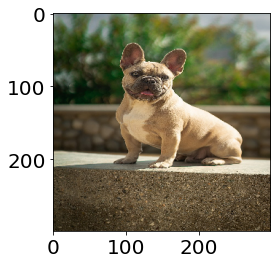

In [0]:
# predicting images
img = image.load_img('frenchie.jpg', target_size=(img_width, img_height))
x = image.img_to_array(img)
x = np.expand_dims(img, axis=0)/255.

# Get predicted probabilities for 120 class labels
pred_classes = model.predict(x, batch_size=16)

# Display image being classified
plt.imshow(img)

# Get index of highest probability and use it to get class label
classes[np.argmax(pred_classes)]